In [1]:
# Imports
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

In [2]:
# Data
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

In [3]:
# Create dataset to load the images
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = './A'
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img

In [4]:
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
])
# Load the dataset
dataset = LandscapeDataset(transform=transform)

# Split the data into train and test data
train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

# Load the train and set data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [5]:
# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

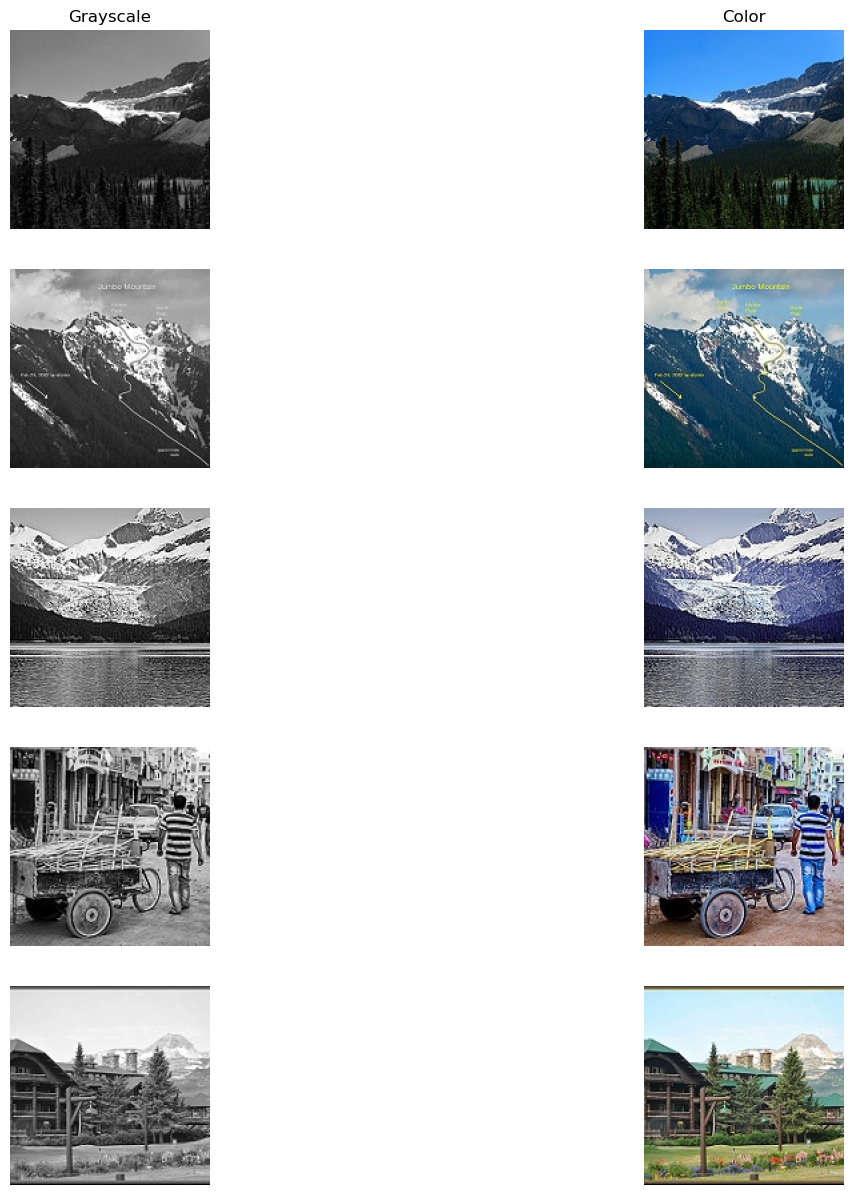

In [6]:
color, gray = next(iter(trainloader))
show_images(color, gray)
     

In [7]:
# Training Variables

EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# Create the autoencoder model
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x29
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Upsample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

In [9]:
# Initialize the model
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"

'Total Number of trainable parameters of this model are: 3,470,659'

In [10]:
# Initialize the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
# Définir la boucle d'entraînement
for epoch in range(EPOCHS):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Faire des prédictions avec le modèle
        predictions = model(gray_img)

        optimizer.zero_grad()
        # Calculer la perte entre l'image colorée et l'image prédite
        loss = criterion(color_img, predictions)

        # Calculer les gradients et effectuer la rétropropagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch: {epoch + 1}, Loss: {running_loss:.6f}')

print('Training Finished!')

  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 1, Loss: 3.271827


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 2, Loss: 1.713118


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 3, Loss: 1.475681


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 4, Loss: 1.373689


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 5, Loss: 1.309997


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 6, Loss: 1.282734


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 7, Loss: 1.241280


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 8, Loss: 1.227205


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 9, Loss: 1.206800


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.196599
Training Finished!


In [12]:
# Tester sur les données de test
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)

        loss = criterion(prediction, color_img)
        total_loss += loss.item()

f"Total Testing loss is: {total_loss/ len(testloader):.3f}"

  0%|          | 0/45 [00:00<?, ?it/s]

'Total Testing loss is: 0.007'

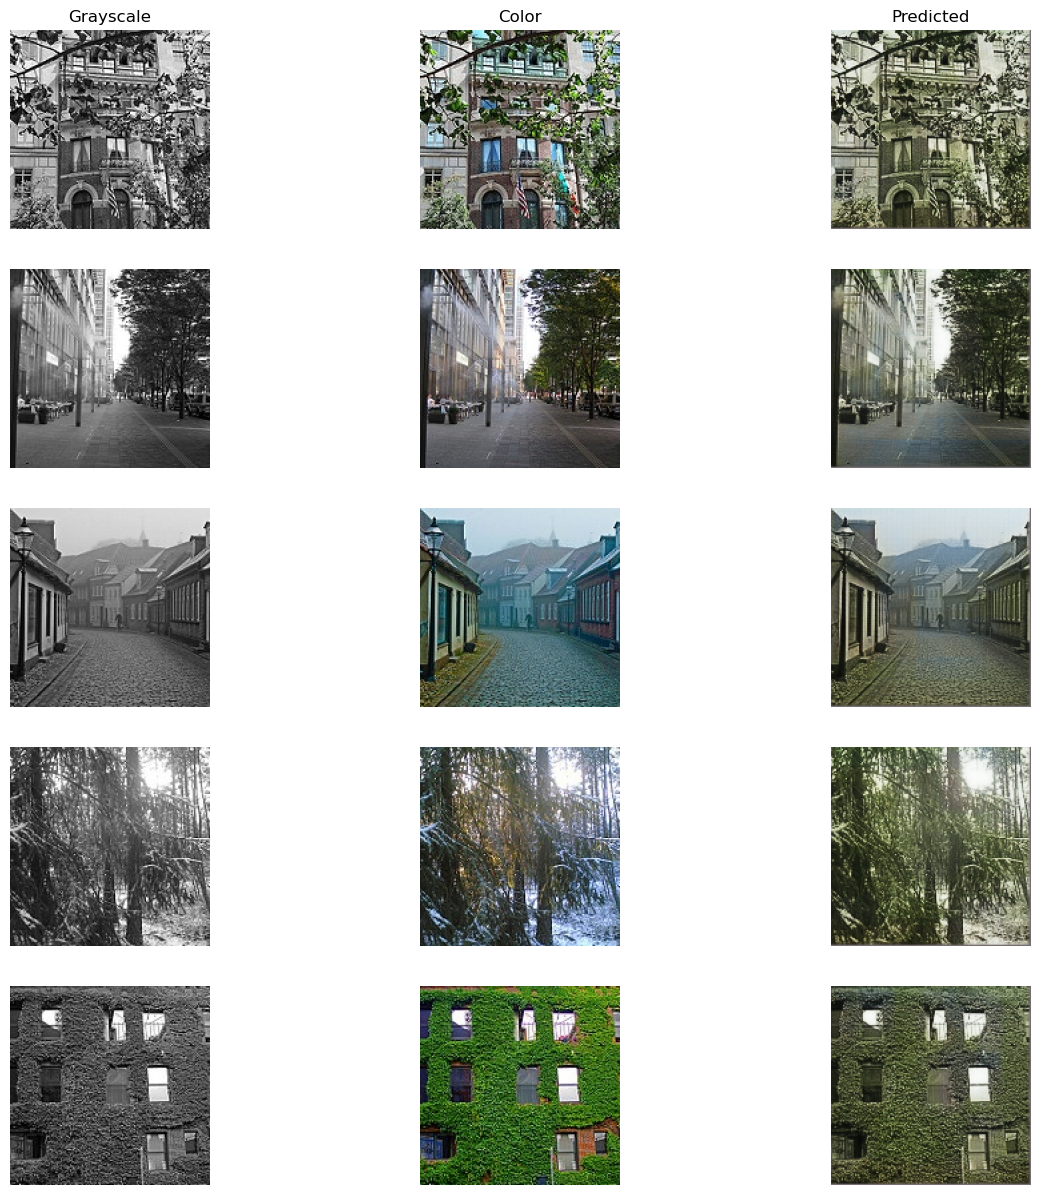

In [13]:


# Visualiser quelques prédictions
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()

     

show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu())
     


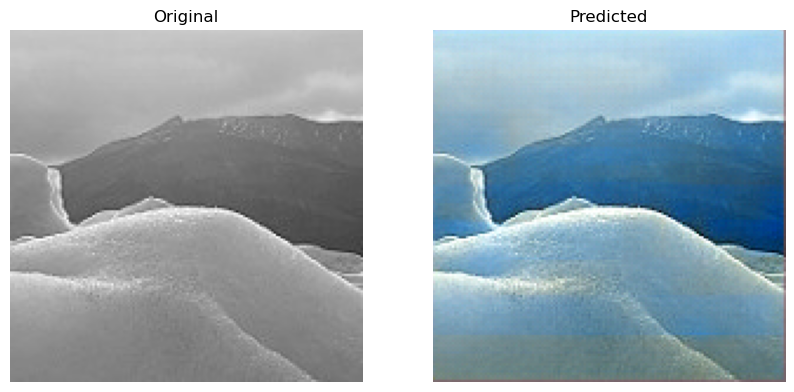

In [56]:
from PIL import Image, ImageEnhance
import cv2
import numpy as np

def enhance_pixels_to_match(original, predicted):
    """
    Améliorer la qualité de l'image prédite pour qu'elle corresponde à l'image originale.
    """
    original_array = np.array(original)
    predicted_array = np.array(predicted)

    # Assurer la même résolution
    predicted_array = cv2.resize(predicted_array, (original_array.shape[1], original_array.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Ajuster les couleurs pour correspondre à l'original
    predicted_array = cv2.cvtColor(predicted_array, cv2.COLOR_RGB2LAB)
    original_array = cv2.cvtColor(original_array, cv2.COLOR_RGB2LAB)
    
    # Transférer les couleurs de l'original à la prédiction
    l, a, b = cv2.split(predicted_array)
    l_ref, a_ref, b_ref = cv2.split(original_array)
    l = cv2.addWeighted(l, 0.5, l_ref, 0.5, 0)
    predicted_array = cv2.merge((l, a, b))
    predicted_array = cv2.cvtColor(predicted_array, cv2.COLOR_LAB2RGB)

    # Retour à PIL
    return Image.fromarray(predicted_array)

def enhance_colors(image):
    """
    Améliorer la saturation et le contraste pour rendre les couleurs plus vives et claires.
    """
    enhancer_contrast = ImageEnhance.Contrast(image)
    contrast_image = enhancer_contrast.enhance(1.3)  # Augmenter le contraste

    enhancer_saturation = ImageEnhance.Color(contrast_image)
    enhanced_image = enhancer_saturation.enhance(1.5)  # Augmenter la saturation pour plus de vivacité

    return enhanced_image

def balance_brightness(original, predicted):
    """
    Équilibrer la luminosité de l'image prédite par rapport à l'image originale.
    """
    original_array = np.array(original)
    predicted_array = np.array(predicted)
    
    # Convertir les images en niveaux de gris pour calculer la luminosité moyenne
    original_gray = cv2.cvtColor(original_array, cv2.COLOR_RGB2GRAY)
    predicted_gray = cv2.cvtColor(predicted_array, cv2.COLOR_RGB2GRAY)
    
    # Calculer la luminosité moyenne des images
    original_brightness = np.mean(original_gray)
    predicted_brightness = np.mean(predicted_gray)
    
    # Calculer un facteur de correction pour ajuster la luminosité
    brightness_factor = original_brightness / predicted_brightness
    
    # Appliquer l'ajustement à l'image prédite
    enhancer_brightness = ImageEnhance.Brightness(predicted)
    balanced_image = enhancer_brightness.enhance(brightness_factor)  # Ajuster selon le facteur de luminosité
    
    return balanced_image

def predict_and_show(image_path, model, device='cpu'):
    # Charger l'image originale
    original_img = Image.open(image_path).convert('RGB')
    gray_img = original_img.convert('L')  # Convertir en niveaux de gris
    gray_img = gray_img.resize((150, 150))  # Redimensionner à la taille de l'entrée du modèle

    # Transformation pour le modèle
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    gray_img_tensor = transform(gray_img).unsqueeze(0).to(device)  # Ajouter une dimension batch
    
    # Prédiction avec le modèle
    model.eval()
    with torch.no_grad():
        predicted_img_tensor = model(gray_img_tensor)

    # Post-traitement : clamp entre 0 et 1
    predicted_img_tensor = torch.clamp(predicted_img_tensor, 0, 1)
    predicted_img_pil = transforms.ToPILImage()(predicted_img_tensor.squeeze().cpu())

    # Amélioration pour correspondre à l'original
    predicted_img_pil = enhance_pixels_to_match(original_img, predicted_img_pil)

    # Appliquer l'amélioration des couleurs (saturation et contraste)
    predicted_img_pil = enhance_colors(predicted_img_pil)

    # Appliquer un filtre pour équilibrer la luminosité de l'image prédite
    predicted_img_pil = balance_brightness(original_img, predicted_img_pil)

    # Afficher les images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Original')
    axs[1].set_title('Predicted')
    
    axs[0].imshow(original_img)
    axs[0].axis('off')
    
    axs[1].imshow(predicted_img_pil)
    axs[1].axis('off')

    plt.show()

# Exemple d'utilisation 
image_path = './35.jpg'  # Remplacez par le chemin réel
predict_and_show(image_path, model, device='cpu')
